In [78]:
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from skimage import measure

from dataset import TrainData
from evaluate import analyze
from train import create_model
from ensemble import Ensemble

In [28]:
input_dir = "/storage/kaggle/tgs"
model_dir = "/storage/models/tgs/scse"
img_size_original = 101

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

In [15]:
model = create_model(pretrained=False).to(device)
model.load_state_dict(torch.load("{}/model.pth".format(model_dir), map_location=device))

In [16]:
train_data = TrainData(input_dir)
df = train_data.val_set_df

In [17]:
analyze(Ensemble([model]), df, use_tta=False)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



threshold: 0.500, precision: 0.838, precision_crf: 0.831, precision_otsu: 0.613, precision_max: 0.846, precision_avg: 0.839, precision_cc: 0.842

                precisions_otsu  precisions_crf  precisions_avg  precisions  coverage_class  precisions_max  precisions_cc
coverage_class                                                                                                            
0                      0.401899        0.977848        0.974684    0.974684             316        0.977848       0.974684
1                      0.411538        0.354615        0.411538    0.410000             130        0.434615       0.411538
2                      0.735185        0.729630        0.731481    0.731481              54        0.737037       0.735185
3                      0.788235        0.792157        0.790196    0.788235              51        0.798039       0.790196
4                      0.950000        0.947059        0.950000    0.947059              34        0.950000       0

(0.5,
 {0: 0.5,
  1: 0.44,
  2: 0.36,
  3: 0.34,
  4: 0.42,
  5: 0.32,
  6: 0.26,
  7: 0.54,
  8: 0.24,
  9: 0.12,
  10: 0.5})

In [87]:
def is_vertical_mask(mask):
    s = np.sort(np.unique(np.sum(mask, axis=0)))
    return len(s) == 2 and s[0] == 0 and s[1] == img_size_original

df["has_vertical_mask"] = df.masks.map(is_vertical_mask)

In [84]:
df["component_count"] = df.masks.map(np.array).map(measure.label).map(np.unique).map(len)
df["predictions_component_count"] = df.prediction_masks.map(np.array).map(measure.label).map(np.unique).map(len)

77


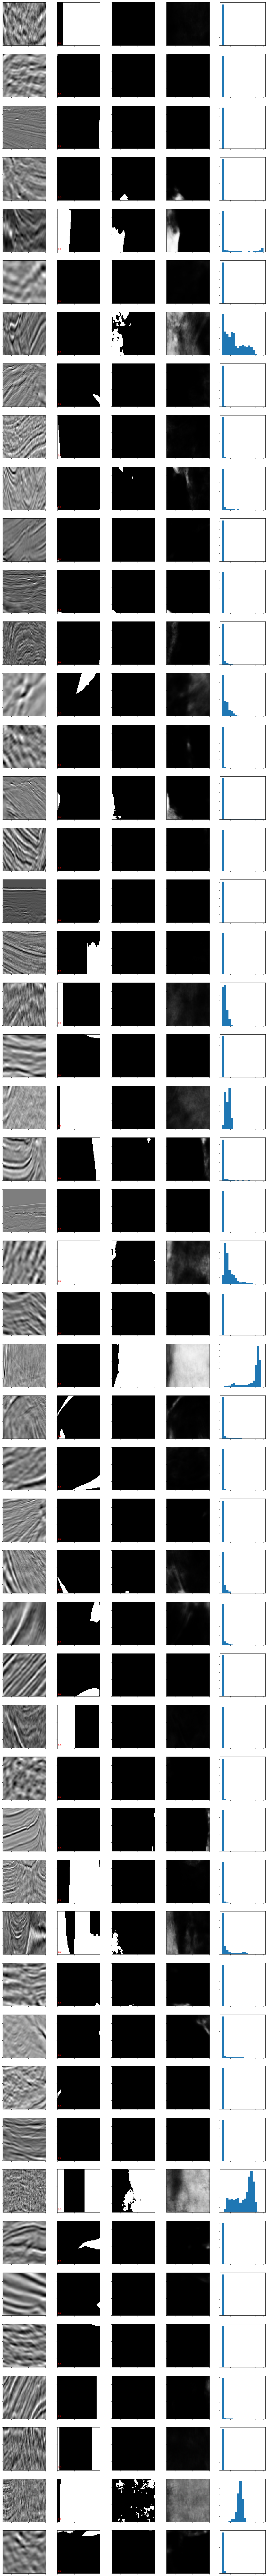

In [91]:
target_ids = df.index[(df.precisions == 0.0)]

ncols = 5
nrows = min(50, len(target_ids))
ncells = ncols * nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(20, int(20 * nrows / ncols)))
print(len(target_ids))
random_image_indexes = random.sample(range(len(target_ids)), min(ncells // ncols, len(target_ids)))
for i, idx in enumerate(target_ids[random_image_indexes]):
    image = df.loc[idx].images
    mask = df.loc[idx].masks
    prediction_mask = df.loc[idx].prediction_masks
    predictions = df.loc[idx].predictions
    precision = df.loc[idx].precisions
    axs[(ncols * i + 0) // ncols, (ncols * i + 0) % ncols].imshow(image, cmap="gray")
    axs[(ncols * i + 1) // ncols, (ncols * i + 1) % ncols].imshow(mask, cmap="gray", vmin=0.0, vmax=1.0)
    axs[(ncols * i + 2) // ncols, (ncols * i + 2) % ncols].imshow(prediction_mask, cmap="gray", vmin=0.0, vmax=1.0)
    axs[(ncols * i + 3) // ncols, (ncols * i + 3) % ncols].imshow(predictions, cmap="gray", vmin=0.0, vmax=1.0)
    axs[(ncols * i + 4) // ncols, (ncols * i + 4) % ncols].hist(predictions.flatten(), bins=np.linspace(0, 1, 20))
    axs[(ncols * i + 1) // ncols, (ncols * i + 1) % ncols].text(1, img_size_original - 5, precision, color="red")
for ax in axs.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])

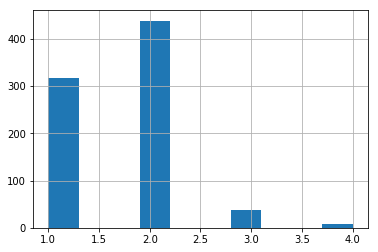

In [82]:
df.masks.map(np.array).map(measure.label).map(np.unique).map(len).hist()

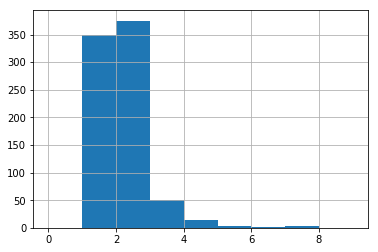

In [83]:
df.prediction_masks.map(np.array).map(measure.label).map(np.unique).map(len).hist(bins=range(10))